# Converting image to Hough space and calculating the number of lines

In [70]:
import os 
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage

In [9]:
%matplotlib inline

## Load sample image

In [107]:
# Help functions

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def load_data(image_name):    
    '''
    Load images from the "faces_imgs" directory
    Images are in JPG and we convert it to gray scale images
    '''
    img = mpimg.imread(image_name)
    img = rgb2gray(img)
    
    return img

def visualize(img, format=None, gray=False):
    if img.shape[0] == 3:
        img = img.transpose(1,2,0)
    plt.imshow(img, format)
    plt.show()

In [108]:
sample_image_name = 'marker_cut_rgb_512.png'

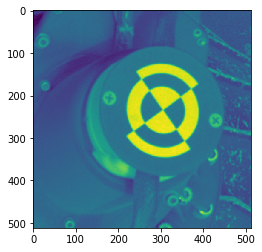

In [109]:
sample_image = load_data(sample_image_name)
sample_image_arr = np.array(sample_image)
visualize(sample_image)

## Hough space math background

A line in Cartesian form could be expressed in the equation:

*y = mx + b*

where: 

m = gradient or slope of the line (rise/run)   
b = y-intercept

![Example of two points with various intersections](hough_mb_parameter_space.png)

If we have two example points, for each point we can set different values of *m* and therefore obtain different intersections, and we can compute corresponding *b* values.

All points on a line in image space intersect at a common point in parameter space. This common point *(m, b)* represents the line in image space.
Unfortunately, the slope, *m*, is undefined when the line is vertical (division by 0!).
To overcome this, we use another parameter space, the hough space.

## Polar coordinate system

A line in Polar coordinate system could be expressed in the equation:

*ρ = x cos θ + y sin θ*

where:

*ρ (rho)* = distance from origin to the line. [-max_dist to max_dist].
          max_dist is the diagonal length of the image.  
*θ* = angle from origin to the line. [-90° to 90°]


## Algorithm steps

1. **Corner or edge detection**. We can use **Canny, Sobel or Adaptive Thresholding algorithm**. The result of this step is binary or grey image with zeros indicating non-edges and ones indicating edges. The result is now interpreted as our input image

2. **Rho range and Theta range creation.** ρ ranges from *-max_dist* to *+max_dist* where *max_dist* is the diagonal length of the input image (the number of diagonal entries in image matrix). θ ranges from *-90∘ to 90∘*. 

3. **Hough accumulator of θ vs ρ**. Is a 2D array with the number of rows equal to the number of ρ values and the number of columns equal to number of θ values.

4. **Accumulator voting**. For each of the edge points and for each of θ we find the nearest corresponding ρ valeu and increment it index in the accumulator. Each element in our accumulator matrix tells how many pixels contributed votes for line candidate with tuple of parameters (ρ, θ)

5. **Peak search**. Maximum values in the accumulator matrix indicate parameters of most probable lines in the image. Peaks could be found by applying some threshold.

## Convolution operator

Convolution is a simple mathematical operation which is fundamental to many common image processing operators. Convolution provides a way of multiplying together two arrays of numbers, generally of different sizes, but of the same dimensionality, to produce a third array of numbers of the same dimensionality. 

This can be used in image processing to implement operators whose output pixel values are simple linear combinations of certain input pixel values.

If the image has M rows and N columns, and the kernel has m rows and n columns, then the size of the output image will have *M - m + 1* rows, and *N - n + 1* columns.

## Canny Edge Detector (CED)

*The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. Canny also produced a computational theory of edge detection explaining why the technique works (C)*

The general algorithm goes in five steps:

- Noise reduction
- Image gradient calculation
- Non-maximum suppression (*optional*)
- Double threshold (*optional*)
- Edge tracking


The algorithm is based on grayscale images, so the input image should be grayscale

### Noise reduction

Since this algorithm is based on gradient calculation it is very sensitive to image noise and the **noise reduction** stage is crucial.
The easiest approach is to add Gaussian blur to the image to smooth it. We need to select the kernel size of the Gaussian Filter, which will set the amount of blur.

![Gaussian Kernel formula](gaussian_kernel_formula.png)

In [77]:
def gaussian_kernel(kernel_size, sigma = 1):
    '''
    Create a Gaussian Kernel of given size
    for applying blur to image
    '''
    
    kernel_size = int(kernel_size) // 2
    x, y = np.mgrid[-kernel_size:kernel_size+1, -kernel_size:kernel_size+1] 
    norm = 1 / (2.0 * np.pi * sigma**2)
    kernel = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * norm
    
    return kernel

### Gradient Calculation

Gradient calculation detects the edge intensity and direction by calculating the gradient of the whole image using edge detection operators.

*Edges correspond to a change of pixels’ intensity. To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y)*

After image smoothing phase the *Ix* and *Iy* are calculated. It could be implemented with Sobel Kernels *Kx* and *Ky*.

![Sobel Filters](sobel_filters.png)

![Magnitude](magnitude.png)

In [91]:
def sobel_filters(image):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(image, Kx)
    Iy = ndimage.filters.convolve(image, Ky)
    
    g = np.hypot(Ix, Iy)
    g = g / g.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (g, theta)

### Non-maximum suppression

This approach is used to have thin edges in our images. Non-thin edges could be encountered due to various reasons - one of them is blur. The princimple is quite simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with maximum value in the edge directions.

The purpose of the algorithm is to check if the pixels on the same direction are more or less intense than the ones being processed.

The algorithm flow:

- Create zeros matrix of the same size as the original gradient matrix
- Identify the edge directin based on the angle value from the matrix of angles
- Check if the pixels in the same direction of the current processed pixel have higher intensity

In [95]:
def non_max_suppression(image, diagonal):
    '''
    Inputs and image and matrix of angles
    and outputs a matrix of thinned edges
    '''
    
    m, n = image.shape
    
    # Create zeros matrix of gradient size
    zer_proc = np.zeros((m,n), dtype = np.int32)
    
    # Calculate angles of the pixels
    angle = diagonal * 180. / np.pi
    
    # Supress zero angles
    angle[angle <0] += 180
    
    for i in range(1, m-1):
        for j in range(1, n-1):
            try :
                # Get the values of next and previous pixel in direction
                next_pixel = image[i, j+1]
                previous_pixel = image[i, j-1]
                
                #0°
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    next_pixel = image[i, j+1]
                    previous_pixel = image[i, j-1]
                    
                #45°
                elif (22.5 <= angle[i,j] < 67.5):
                    next_pixel = image[i+1, j-1]
                    previous_pixel = image[i-1, j+1]
                    
                #90°
                elif (67.5 <= angle[i,j] < 112.5):
                    next_pixel = image[i+1, j]
                    previous_pixel = image[i-1, j]
                    
                #135°
                elif (112.5 <= angle[i,j] < 157.5):
                    next_pixel = image[i-1, j-1]
                    previous_pixel = image[i+1, j+1]

                    
                if (image[i,j] >= next_pixel) and (image[i,j] >= previous_pixel):
                    zer_proc[i,j] = image[i,j]
                else:
                    zer_proc[i,j] = 0
                
            except IndexError:
                pass
            
    return zer_proc
                

In [99]:
# Test the functions

smoothed_image = ndimage.filters.convolve(sample_image_arr, gaussian_kernel(5))

grad_matrix, theta_matrix = sobel_filters(smoothed_image)
non_max_image = non_max_suppression(grad_matrix, theta_matrix)

imgplot = plt.imshow(non_max_image)

RuntimeError: filter weights array has incorrect shape.

In [14]:
# Hyperparameters, that could be adjusted

theta_min = -90.0
theta_max = 90.0

In [21]:
def HoughLines(image):
    '''
    Takes an input image as numpy array after
    some transformation (Canny, Sobel, Adaptive thresholding)
    and returns thetas, rhos and accumulator
    '''
    
    # Rho range and Theta range creation
    
    width, height = image.shape[0], image.shape[1]
    thetas = np.deg2rad(np.arange(theta_min, theta_max))
    
    max_distance = np.ceil(np.sqrt(width**2 + height**2))
    rhos = np.linspace(-max_distance, max_distance, max_distance * 2)
    
    # Calculate the sinus and cosinus of theta values
    
    theta_cos = np.cos(thetas)
    theta_sin = np.sin(thetas)
    
    # Create Hough accumulator
    
    accumulator = np.zeros(2 * max_distance, len(thetas), dtype = np.uint64)
    
    # Edge indexes
    
    y_id, x_id = np.nonzero(image)
    
    # Accumulator voting
    
    # Go through every index of column indexes to edges
    for i in range(len(x_id)):
        
        x = x_id[i]
        y = y_id[i]
        
        # And vote through every theta
        for theta_i in range(len(thetas)):
            rho = np.round(x * theta_cos[theta_i] + y * theta_sin[theta_i]) + max_distance
            accumulator[rho, t_idx] += 1
            
    return thetas, rhos, accumulator